In [ ]:
%pip install snowflake-connector-python==2.3.5

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './scripts')
from snowflakeDbConnector import SnowflakeDbConnector

In [ ]:
client = 'colgate'
snowflake_db_connector = SnowflakeDbConnector()
database_query = f'''
        use database brands_{client};
        '''
snowflake_db_connector.getResultForQuery(database_query)

status
0  Statement executed successfully.

In [ ]:
dataframe_query = f'''
        select CAMPAIGN_ID,CAMPAIGN_NAME, sum(CAMPAIGN_BUDGET),sum(cost),sum(clicks),sum(IMPRESSIONS),sum(ATTRIBUTEDSALES30D),REPORT_DATE
        from ams.campaigns_report a
        where CAMPAIGN_ID=194887345412573
        and REPORT_DATE='2020-07-12'
        and CAMPAIGN_STATUS='enabled'
        group by  CAMPAIGN_ID,CAMPAIGN_NAME,REPORT_DATE
        limit 1000 ;
        '''

keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

CAMPAIGN_ID         CAMPAIGN_NAME SUM(CAMPAIGN_BUDGET) SUM(COST)  \
0  194887345412573  Equity - Brand - All                63.00     30.84   

   SUM(CLICKS)  SUM(IMPRESSIONS) SUM(ATTRIBUTEDSALES30D) REPORT_DATE  
0           20              6738                  144.07  2020-07-12

In [ ]:
dataframe_query = f'''
        select a.PROFILE_ID,a.CAMPAIGN_ID,a.KEYWORD_TEXT,a.MATCH_TYPE,a.CLICKS as Clicks, 
        a.KEYWORDBID as KEYWORDBID,
        a.IMPRESSIONS as IMPRESSIONS, 
        (a.CLICKS)*100 /(a.IMPRESSIONS+1) as CTR,
        REPORT_DATE
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        and CAMPAIGN_ID like '144%'
        and IMPRESSIONS<>0 and CLICKS<>0
        and extract(week from REPORT_DATE)=51
        order by a.PROFILE_ID,a.MATCH_TYPE
        limit 1000 ;'''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)
keywords_report_df2

PROFILE_ID         CAMPAIGN_ID  \
0    1414667831379156  144347278762240512   
1    1414667831379156  144226801509814776   
2    1414667831379156  144204585704079827   
3    1414667831379156  144347278762240512   
4    1414667831379156  144370988295674110   
..                ...                 ...   
995  1414667831379156  144191467259384329   
996  1414667831379156  144191467259384329   
997  1414667831379156  144241772828923870   
998  1414667831379156  144375196674479666   
999  1414667831379156  144128244260792017   

                            KEYWORD_TEXT MATCH_TYPE  CLICKS    KEYWORDBID  \
0            +womens +deodorant +natural      BROAD       1  3.9700000000   
1                       +mouthwash +toms      BROAD       5  1.7500000000   
2           toms of maine antiperspirant      BROAD       1  2.5200000000   
3                      +deodorant +women      BROAD       1  2.5900000000   
4                        +lavender +soap      BROAD       1  1.1500000000   
..                                   ...        ...     ...           ...   
995                      mint toothpaste     PHRASE       1  1.5200000000   
996                  natural toothpastes     PHRASE       1  3.5500000000   
997  toms of maine strawberry toothpaste     PHRASE       1  0.7500000000   
998                       antiperspirant     PHRASE       5  2.8500000000   
999                            deodorant     PHRASE       4  6.7000000000   

     IMPRESSIONS        CTR REPORT_DATE  
0            285   0.349650  2020-12-20  
1             87   5.681818  2020-12-19  
2            167   0.595238  2021-12-22  
3           1521   0.065703  2020-12-15  
4            177   0.561798  2020-12-18  
..           ...        ...         ...  
995            7  12.500000  2021-12-22  
996           28   3.448276  2021-12-20  
997            4  20.000000  2021-12-20  
998         1231   0.405844  2021-12-20  
999         2098   0.190567  2021-12-20  

[1000 rows x 9 columns]

In [ ]:
dataframe_query = f'''
        select SEARCH,min(SKU_SEARCH_RANK),TO_DATE(SCRAPE_DATE) as SCRAPE_DATE
        from aramus.search_data_archive 
        where SCRAPE_DATE like '20%'
        and SKU_SEARCH_RANK is not null
        and extract(week from SCRAPE_DATE)=51
        group by SEARCH,TO_DATE(SCRAPE_DATE)
        order by SCRAPE_DATE
        limit 1000 ;'''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)
keywords_report_df2

SEARCH  MIN(SKU_SEARCH_RANK) SCRAPE_DATE
0               hand soap dispenser                     1  2018-12-21
1                         deodorant                     1  2018-12-21
2                  womens deodorant                     1  2018-12-21
3                     act mouthwash                     1  2018-12-21
4              toothpaste sensitive                     1  2018-12-21
..                              ...                   ...         ...
995             deodorant gel women                     1  2019-12-16
996         antibacterial hand soap                     1  2019-12-16
997          prepasted toothbrushes                     1  2019-12-16
998     cleure toothpaste sensitive                     1  2019-12-16
999  travel size toothpaste in bulk                     1  2019-12-16

[1000 rows x 3 columns]

In [ ]:
# ---Final query

dataframe_query = f'''
        select distinct
        a.KEYWORD_TEXT,
        case a.MATCH_TYPE
        when 'EXACT' then 0.45490
        when 'PHRASE' then 0.27976
        when 'BROAD' then 0.4242 end as match_score,
        a.CLICKS as Clicks, 
        a.KEYWORDBID,a.IMPRESSIONS,b.SEARCH, b.rank,a.CTR, b.SCRAPE_DATE, a.REPORT_DATE
        from
        (
        select a.PROFILE_ID,a.CAMPAIGN_ID,a.KEYWORD_TEXT,a.MATCH_TYPE,a.CLICKS as Clicks, 
        a.KEYWORDBID as KEYWORDBID,
        a.IMPRESSIONS as IMPRESSIONS, 
        (a.CLICKS)*100 /(a.IMPRESSIONS+1) as CTR,
        REPORT_DATE
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        and CAMPAIGN_ID like '1%'
        and IMPRESSIONS<>0 and CLICKS<>0
        and extract(week from REPORT_DATE)=51
        and a.MATCH_TYPE is not null
        order by a.PROFILE_ID,a.MATCH_TYPE
        limit 1000) a 
        join
        (select SEARCH,avg(SKU_SEARCH_RANK) as rank,TO_DATE(SCRAPE_DATE) as SCRAPE_DATE
        from aramus.search_data_archive 
        where SCRAPE_DATE like '202%'
        and SKU_SEARCH_RANK is not null
        and extract(week from SCRAPE_DATE)=51
        group by SEARCH,TO_DATE(SCRAPE_DATE)
        order by SCRAPE_DATE
        ) b
        on contains(b.SEARCH,a.KEYWORD_TEXT) and b.SCRAPE_DATE=a.REPORT_DATE;
        '''
CTR_df = snowflake_db_connector.getResultForQuery(dataframe_query)
CTR_df

KEYWORD_TEXT MATCH_SCORE  CLICKS    KEYWORDBID  \
0      kids toothpaste strawberry     0.42420       2  1.5200000000   
1        toothpaste fluoride free     0.42420       1  1.7500000000   
2        toothpaste fluoride free     0.42420       1  1.7500000000   
3               organic deodorant     0.42420       1  1.5700000000   
4               natural deodorant     0.42420       3  1.5200000000   
...                           ...         ...     ...           ...   
11554                    soap bar     0.45490       3  3.5000000000   
11555                    soap bar     0.45490       3  3.5000000000   
11556                    soap bar     0.45490       3  3.5000000000   
11557                    soap bar     0.45490       3  3.5000000000   
11558                    soap bar     0.45490       3  3.5000000000   

       IMPRESSIONS                               SEARCH       RANK       CTR  \
0              108           kids toothpaste strawberry  33.000000  1.834862   
1               45        baby toothpaste fluoride free  35.500000  2.173913   
2               45       jason toothpaste fluoride free  37.000000  2.173913   
3              322          organic deodorant for women  34.500000  0.309598   
4              314                    natural deodorant  35.500000  0.952381   
...            ...                                  ...        ...       ...   
11554         1363                        soap bar zest  31.500000  0.219941   
11555         1363                        bulk soap bar  32.500000  0.219941   
11556         1363                        toms soap bar  32.500000  0.219941   
11557         1363  bulk soap bars individually wrapped  33.261538  0.219941   
11558         1363                      men's soap bars  32.000000  0.219941   

      SCRAPE_DATE REPORT_DATE  
0      2021-12-26  2021-12-26  
1      2021-12-24  2021-12-24  
2      2021-12-24  2021-12-24  
3      2021-12-24  2021-12-24  
4      2021-12-24  2021-12-24  
...           ...         ...  
11554  2020-12-15  2020-12-15  
11555  2020-12-15  2020-12-15  
11556  2020-12-15  2020-12-15  
11557  2020-12-15  2020-12-15  
11558  2020-12-15  2020-12-15  

[11559 rows x 10 columns]

In [ ]:
# for getting numbers per match_type

dataframe_query = f'''
        select a.PROFILE_ID,a.MATCH_TYPE,sum(a.CLICKS) as total_Clicks,sum(a.KEYWORDBID) as total_KEYWORDBID,sum(a.IMPRESSIONS) as total_IMPRESSIONS, sum(a.CLICKS)*100 /(sum(a.IMPRESSIONS)+1) as CTR
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        group by a.PROFILE_ID,a.MATCH_TYPE
        order by a.PROFILE_ID,a.MATCH_TYPE
        limit 1000 ;
        '''
        
    
# #  scaling down the values to 0-1
# dataframe_query = f'''
#         select a, c/max(c), d/max(d), e/max(e) 
#         from
#         (
#         select a.MATCH_TYPE as a,sum(a.CLICKS) as c,sum(a.KEYWORDBID) as d,sum(a.IMPRESSIONS) as e
#         from ams.keywords_headline_report a
#         where a.KEYWORDSTATUS='Enabled'
#         and a.PROFILE_ID=1414667831379156
#         group by a.MATCH_TYPE
#         ) as src
#         group by a;
#         '''
    
    
        
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

PROFILE_ID MATCH_TYPE  TOTAL_CLICKS     TOTAL_KEYWORDBID  \
0  1414667831379156      BROAD         30478  10197048.1950700000   
1  1414667831379156      EXACT        115408  27097568.6121300000   
2  1414667831379156     PHRASE        137510  22035048.5068700000   
3    48152324644388      BROAD         24207   2601110.9498400000   
4    48152324644388      EXACT        163175  10237261.4735600000   
5    48152324644388     PHRASE         85681   4401893.7361200000   

   TOTAL_IMPRESSIONS       CTR  
0            7794501  0.391019  
1           27864067  0.414182  
2           50583676  0.271847  
3            5290746  0.457535  
4           32922415  0.495635  
5           29782339  0.287691

In [ ]:
# for getting numbers per match_type

dataframe_query = f'''
        SELECT MATCH_TYPE, AVG(ctr)
        FROM 
        (
        select a.PROFILE_ID,a.MATCH_TYPE,sum(a.CLICKS) as total_Clicks,sum(a.KEYWORDBID) as total_KEYWORDBID,sum(a.IMPRESSIONS) as total_IMPRESSIONS, sum(a.CLICKS)*100 /(sum(a.IMPRESSIONS)+1) as CTR
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        group by a.PROFILE_ID,a.MATCH_TYPE
        order by a.PROFILE_ID,a.MATCH_TYPE
        limit 1000
        )
        GROUP BY MATCH_TYPE;
        '''    
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)
keywords_report_df2

MATCH_TYPE        AVG(CTR)
0      BROAD  0.424277000000
1     PHRASE  0.279769000000
2      EXACT  0.454908500000

In [ ]:
#HENCE CHOSEN WEIGHTS FOR THIS MATCH TYPE AS :
# exact - 1
# BROAD - 0.932664
# PHRASE - 0.61500059902

KEYWORD_TEXT MATCH_SCORE  CLICKS    KEYWORDBID  \
12169                     toothpaste     0.45490       1  4.0000000000   
5934                      toothpaste     0.45490       1  4.0000000000   
5928                      toothpaste     0.45490       1  4.0000000000   
5929                      toothpaste     0.45490       1  4.0000000000   
5930                      toothpaste     0.45490       1  4.0000000000   
...                              ...         ...     ...           ...   
5568   kids fluoride free toothpaste     0.45490       1  2.2200000000   
9624               toothpaste fennel     0.42420       1  2.2700000000   
6300                soap bar in bulk     0.45490       1  1.2600000000   
9515              toms deodorant men     0.27976       1  2.2200000000   
384                 bar soap in bulk     0.45490       1  3.0000000000   

       IMPRESSIONS                             SEARCH       RANK       CTR  \
12169         8733  children toothpaste with fluoride  32.000000  0.790514   
5934          8733         toothpaste in prime pantry  30.500000  1.084599   
5928          8733                  toothpaste 3 pack  32.500000  1.084599   
5929          8733              peppermint toothpaste  32.000000  1.084599   
5930          8733           toothpaste for whitening  32.500000  1.084599   
...            ...                                ...        ...       ...   
5568             3      kids fluoride free toothpaste  34.500000  0.280112   
9624             3          natural toothpaste fennel  32.000000  0.757576   
6300             3                   soap bar in bulk  32.000000  0.013310   
9515             2                 toms deodorant men  35.000000  0.203114   
384              1                   bar soap in bulk  32.500000  0.757576   

      SCRAPE_DATE REPORT_DATE  
12169  2020-12-14  2020-12-14  
5934   2020-12-14  2020-12-14  
5928   2020-12-14  2020-12-14  
5929   2020-12-14  2020-12-14  
5930   2020-12-14  2020-12-14  
...           ...         ...  
5568   2021-12-21  2021-12-21  
9624   2021-12-26  2021-12-26  
6300   2020-12-18  2020-12-18  
9515   2021-12-24  2021-12-24  
384    2020-12-19  2020-12-19  

[12738 rows x 10 columns]

In [ ]:
df_Exact=keywords_report_df2.loc[keywords_report_df2['MATCH_TYPE'] == 'EXACT']
df_Phrase=keywords_report_df2.loc[keywords_report_df2['MATCH_TYPE'] == 'PHRASE']
df_Broad=keywords_report_df2.loc[keywords_report_df2['MATCH_TYPE'] == 'BROAD']                                 

In [ ]:
CTR_df

KEYWORD_TEXT MATCH_SCORE  CLICKS    KEYWORDBID  \
0       natural teeth whitening     0.42420       1  6.3600000000   
1      toothpaste fluoride free     0.42420       1  1.7500000000   
2      toothpaste fluoride free     0.42420       1  1.7500000000   
3           deodorant for women     0.42420       1  1.0200000000   
4           deodorant for women     0.42420       1  1.0200000000   
...                         ...         ...     ...           ...   
12733            antiperspirant     0.27976       5  2.8500000000   
12734                toothpaste     0.45490       1  3.0000000000   
12735                toothpaste     0.45490       1  3.0000000000   
12736                toothpaste     0.45490       1  3.0000000000   
12737                toothpaste     0.45490       1  3.0000000000   

       IMPRESSIONS                                    SEARCH       RANK  \
0               80         natural teeth whitening mouthwash  35.000000   
1               51          natural toothpaste fluoride free  29.500000   
2               51      all natural toothpaste fluoride free  35.000000   
3               16      native sensitive deodorant for women  32.000000   
4               16  secret deodorant for women aluminum free  32.500000   
...            ...                                       ...        ...   
12733          532                       24/7 antiperspirant  30.500000   
12734          849                     toothpaste value pack  32.000000   
12735          849        colgate total whitening toothpaste  26.000000   
12736          849                       toothpaste cavities  32.500000   
12737          849        stain removal whitening toothpaste  32.000000   

            CTR SCRAPE_DATE REPORT_DATE  
0      1.234568  2021-12-24  2021-12-24  
1      1.923077  2021-12-23  2021-12-23  
2      1.923077  2021-12-23  2021-12-23  
3      5.882353  2021-12-23  2021-12-23  
4      5.882353  2021-12-23  2021-12-23  
...         ...         ...         ...  
12733  0.938086  2021-12-24  2021-12-24  
12734  0.117647  2020-12-20  2020-12-20  
12735  0.117647  2020-12-20  2020-12-20  
12736  0.117647  2020-12-20  2020-12-20  
12737  0.117647  2020-12-20  2020-12-20  

[12738 rows x 10 columns]

In [ ]:
CTR_df_copy=CTR_df.copy(deep='true')

In [ ]:
CTR_df=CTR_df_copy.copy(deep='true')

In [ ]:
CTR_df.describe()

CLICKS   IMPRESSIONS
count  11559.000000  11559.000000
mean       3.204343   2736.413012
std        4.775432   3356.531330
min        1.000000      1.000000
25%        1.000000    356.000000
50%        2.000000   1444.000000
75%        3.000000   4274.000000
max       35.000000  20804.000000

In [ ]:
# for getting numbers per match_type

CTR_df=CTR_df.drop(['KEYWORD_TEXT','SCRAPE_DATE','SEARCH','REPORT_DATE'], axis = 1)
CTR_df=CTR_df.loc[:8000]

# CTR_df['CAMPAIGN_ID']=keywords_report_df2['CAMPAIGN_ID'].astype(str).astype(int)
CTR_df['CTR']=keywords_report_df2['CTR'].astype(str).astype(float)
CTR_df=CTR_df.sort_values(by=['CLICKS'],ascending=False)


CTR_df

MATCH_SCORE  CLICKS    KEYWORDBID  IMPRESSIONS       RANK       CTR
1628     0.45490      24  4.0000000000         1571  32.500000  0.757576
4679     0.45490      24  1.2300000000         1149  35.500000  0.038670
7969     0.45490      24  4.0000000000         1571  31.000000  0.091458
15       0.45490      24  4.0000000000         1571  31.000000  8.000000
59       0.45490      24  4.0000000000         1571  32.000000  0.952381
...          ...     ...           ...          ...        ...       ...
3890     0.27976       1  3.5500000000          100  39.000000  0.088106
3891     0.27976       1  3.5500000000          100  39.000000  0.088106
3892     0.27976       1  3.5500000000          100  35.500000  0.011450
3893     0.27976       1  3.5500000000          100  35.000000  0.011450
8000     0.45490       1  3.0000000000         2585  33.061538  0.757576

[8001 rows x 6 columns]

In [ ]:
CTR_df.describe()

CLICKS  IMPRESSIONS          CTR
count  8001.000000  8001.000000  8001.000000
mean      3.269466  2868.685164     0.628268
std       3.311439  2517.640821     1.604494
min       1.000000     1.000000     0.011450
25%       1.000000   771.000000     0.053996
50%       2.000000  2585.000000     0.178253
75%       5.000000  4274.000000     0.757576
max      24.000000  8733.000000    50.000000

In [ ]:
def func(x):
    if x < 0.0539:
        return "D"
    elif x < 0.178:
        return "C"
    elif x < 0.757:
        return "B"
    else:
        return 'A'

In [ ]:
CTR_df['CTR'] = CTR_df['CTR'].apply(func)
CTR_df

MATCH_SCORE  CLICKS    KEYWORDBID  IMPRESSIONS       RANK CTR
1628     0.45490      24  4.0000000000         1571  32.500000   A
4679     0.45490      24  1.2300000000         1149  35.500000   D
7969     0.45490      24  4.0000000000         1571  31.000000   C
15       0.45490      24  4.0000000000         1571  31.000000   A
59       0.45490      24  4.0000000000         1571  32.000000   A
...          ...     ...           ...          ...        ...  ..
3890     0.27976       1  3.5500000000          100  39.000000   C
3891     0.27976       1  3.5500000000          100  39.000000   C
3892     0.27976       1  3.5500000000          100  35.500000   D
3893     0.27976       1  3.5500000000          100  35.000000   D
8000     0.45490       1  3.0000000000         2585  33.061538   A

[8001 rows x 6 columns]

In [ ]:
print((CTR_df == 0).sum(axis=0))
print(CTR_df.isnull().sum().sum())

MATCH_SCORE    0
CLICKS         0
KEYWORDBID     0
IMPRESSIONS    0
CTR            0
RANK           0
dtype: int64
0


In [ ]:
CTR_df.groupby('CTR').count()

MATCH_SCORE  CLICKS  KEYWORDBID  IMPRESSIONS  RANK
CTR                                                    
A           2100    2100        2100         2100  2100
B           1931    1931        1931         1931  1931
C           2018    2018        2018         2018  2018
D           1952    1952        1952         1952  1952

In [ ]:
dfa = CTR_df[CTR_df['CTR'] == 'A']
dfb = CTR_df[CTR_df['CTR'] == 'B']
dfc = CTR_df[CTR_df['CTR'] == 'C']
dfd = CTR_df[CTR_df['CTR'] == 'D']
   
CTR_df = pd.concat([dfa.sample(dfd.shape[0]),dfb.sample(dfd.shape[0]),dfc.sample(dfd.shape[0]),dfd])
                                              
CTR_df                                              

MATCH_SCORE  CLICKS    KEYWORDBID  IMPRESSIONS       RANK CTR
712       0.45490       1  4.0000000000         5196  31.000000   A
10621     0.45490       1  4.0000000000         8733  26.500000   A
4438      0.45490       1  3.0000000000         1851  32.000000   A
1289      0.27976       6  2.0200000000         2872  38.000000   A
9366      0.27976       5  1.5200000000         3596  34.500000   A
...           ...     ...           ...          ...        ...  ..
10724     0.45490       1  3.0000000000         1851  26.500000   D
10723     0.45490       1  3.0000000000         1851  32.000000   D
10722     0.45490       1  3.0000000000         1851  32.500000   D
10721     0.45490       1  3.0000000000         1851  32.500000   D
10714     0.45490       1  3.0000000000         1851  32.031746   D

[6312 rows x 6 columns]

In [ ]:
CTR_df.groupby('CTR').count()

MATCH_SCORE  CLICKS  KEYWORDBID  IMPRESSIONS  RANK
CTR                                                    
A           1578    1578        1578         1578  1578
B           1578    1578        1578         1578  1578
C           1578    1578        1578         1578  1578
D           1578    1578        1578         1578  1578

## *DTREE Attempt*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
X = CTR_df[CTR_df.columns[1:-1]]
y = CTR_df['CTR']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=30)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6400, 4) (1601, 4) (6400,) (1601,)


In [ ]:
dtree=DecisionTreeClassifier(criterion='entropy',random_state=30)
dtree.fit(X_train,y_train)


predictions=dtree.predict(X_test)


In [ ]:
print(classification_report(y_test,predictions))
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print('Accuracy')
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           A       0.41      0.63      0.49       380
           B       0.40      0.29      0.33       427
           C       0.36      0.36      0.36       398
           D       0.39      0.30      0.34       396

    accuracy                           0.39      1601
   macro avg       0.39      0.39      0.38      1601
weighted avg       0.39      0.39      0.38      1601

Confusion Matrix
[[240  42  57  41]
 [141 123  92  71]
 [116  64 143  75]
 [ 93  80 104 119]]
Accuracy
0.3903810118675828


![image.png](attachment:image.png)


![image.png](attachment:image.png)



Accuracy is bad, down-sampling Class-A 

In [ ]:
from sklearn import tree
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(16,16),dpi=1024)
tree.plot_tree(dtree)
plt.show()

## RF forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier_rf = RandomForestClassifier(random_state=30, n_jobs=-1, max_depth=10,
                                       n_estimators=100, oob_score=True)

In [ ]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 738 ms, sys: 29.1 ms, total: 767 ms
Wall time: 593 ms


RandomForestClassifier(max_depth=10, n_jobs=-1, oob_score=True, random_state=30)

In [ ]:
# checking the oob score
classifier_rf.oob_score_

0.44484375

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [5,10,15,20],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [50,100,150,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [ ]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
CPU times: user 7.45 s, sys: 13.3 ms, total: 7.46 s
Wall time: 1min 24s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy', verbose=1)

In [ ]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

0.45859375
RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=150,
                       n_jobs=-1, random_state=42)


In [ ]:
rf_best.estimators_

[DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=787846414),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=996406378),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
                        random_state=423734972),
 DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=10,
             

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(200,100))
plot_tree(rf_best.estimators_[5], feature_names = X_train.columns,class_names=['A','B','C','D'],filled=True);

plt.savefig('RF_CTRs.png')

In [ ]:
rf_best.estimators_

[DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=787846414),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=996406378),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=423734972),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                     

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(200,100))
plot_tree(rf_best.estimators_[5], feature_names = X_train.columns,class_names=['A','B','C','D'],filled=True);

In [ ]:
plt.savefig('RF_impressions.png')

<Figure size 432x288 with 0 Axes>

_**MULTI-PERCEPTRON NN**_

In [ ]:
# LET us do scaling on feature this time.
# for taking care of mean-feq centralization, normalized distribution of data
# using Scikit's inbuilt transformer

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# data[['company_name_encoded', 'location', 'minimum_exp', 'maximum_exp']] = sc.fit_transform(data[['company_name_encoded', 'location', 'minimum_exp', 'maximum_exp']])

In [ ]:
CTR_df.columns[1:-1]

Index(['CLICKS', 'KEYWORDBID', 'IMPRESSIONS', 'RANK'], dtype='object')

In [ ]:
CTR_df[['CLICKS', 'KEYWORDBID', 'IMPRESSIONS', 'RANK']]=sc.fit_transform(CTR_df[['CLICKS', 'KEYWORDBID', 'IMPRESSIONS', 'RANK']])

In [ ]:
CTR_df=CTR_df[['CLICKS', 'KEYWORDBID', 'IMPRESSIONS', 'RANK']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(CTR_df, y,test_size=0.20,random_state=30)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6400, 4) (1601, 4) (6400,) (1601,)


In [ ]:
CTR_df[[]]

SyntaxError: invalid syntax (<ipython-input-269-3a0933595ac3>, line 1)

In [ ]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

In [ ]:
classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=1)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_nn = classifier.predict(X_test)
confusion = confusion_matrix(y_pred_nn, y_test)

In [ ]:
impression_class=[y.unique()]
impression_class

[array(['A', 'D', 'C', 'B'], dtype=object)]

<AxesSubplot:>

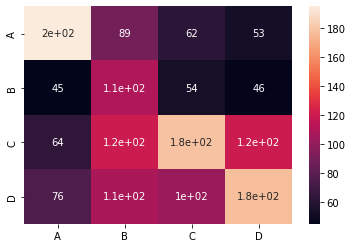

In [ ]:
import seaborn as sns

# sns is seaborn --already imported for tree visualization
sns.heatmap(confusion,xticklabels=['A','B','C','D'], yticklabels=['A','B','C','D'], annot=True)

In [ ]:
print("Accuracy of MLPClassifier")
accuracy(confusion)

print(classification_report(y_test,y_pred_nn))
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred_nn))
print('Accuracy')
print(accuracy_score(y_test,y_pred_nn))

Accuracy of MLPClassifier
              precision    recall  f1-score   support

           A       0.49      0.51      0.50       380
           B       0.43      0.26      0.32       427
           C       0.37      0.45      0.41       398
           D       0.38      0.45      0.41       396

    accuracy                           0.41      1601
   macro avg       0.42      0.42      0.41      1601
weighted avg       0.42      0.41      0.41      1601

Confusion Matrix
[[195  45  64  76]
 [ 89 110 120 108]
 [ 62  54 179 103]
 [ 53  46 120 177]]
Accuracy
0.41286695815115554


In [ ]:
classifier_sgd_invscal = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='sgd',learning_rate='invscaling',random_state=1)

In [ ]:
classifier_sgd_invscal.fit(X_train, y_train)
y_pred_sgd = classifier_sgd_invscal.predict(X_test)


In [ ]:
print(classification_report(y_test,y_pred_sgd))
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred_sgd))
print('Accuracy')
print(accuracy_score(y_test,y_pred_sgd))

              precision    recall  f1-score   support

           A       0.24      0.16      0.19       380
           B       0.26      0.43      0.33       427
           C       0.23      0.34      0.28       398
           D       0.51      0.08      0.14       396

    accuracy                           0.26      1601
   macro avg       0.31      0.25      0.23      1601
weighted avg       0.31      0.26      0.23      1601

Confusion Matrix
[[ 59 200 109  12]
 [ 85 185 155   2]
 [ 66 179 137  16]
 [ 39 144 182  31]]
Accuracy
0.25733916302311055


In [ ]:
plot_confusion_matrix(y_test,y_pred_sgd)
